   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.1 MB/s eta 0:00:00:00:0100:01


/tmp/ipykernel_272/3592816970.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.0


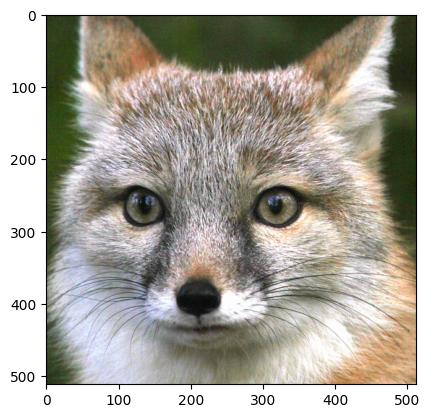

In [23]:
!pip install imageio-ffmpeg
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from IPython.display import HTML
from base64 import b64encode

torch.manual_seed(0)

image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.0
c = [img.shape[0] // 2, img.shape[1] // 2]
r = 256
img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

plt.imshow(img)
plt.show()

In [2]:
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [torch.tensor(x_test, dtype=torch.float32), torch.tensor(img, dtype=torch.float32)]
train_data = [test_data[0][::2, ::2], test_data[1][::2, ::2]]

In [3]:
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = (2.0 * torch.pi * x) @ B.T
        return torch.cat((torch.sin(torch.tensor(x_proj, dtype=torch.float32)), torch.cos(torch.tensor(x_proj, dtype=torch.float32))), dim=-1)

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_layers, num_channels, input_size):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, num_channels))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_channels, num_channels))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(num_channels, 3))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x, B):
        x_mapped = input_mapping(x, B)
        return self.model(x_mapped)

In [5]:
train_data[0].shape

torch.Size([256, 256, 2])

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    input_size = 2 * (B.shape[0] if B is not None else 1)
    model = MLP(*network_size, input_size)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_psnrs, test_psnrs, pred_imgs, xs = [], [], [], []

    for i in tqdm(range(iters), desc='train iter', leave=False):
        model.train()
        optimizer.zero_grad()
        
        if B is not None:
            B = B.float().to(device)

        train_preds = model(train_data[0].to(device), B)
        loss = 0.5 * torch.mean((train_preds - train_data[1].to(device)) ** 2)
        loss.backward()
        optimizer.step()

        if i % 25 == 0:
            model.eval()
            with torch.no_grad():
                train_psnr = -10 * torch.log10(2.0 * loss)
                test_preds = model(test_data[0].to(device), B)
                test_loss = 0.5 * torch.mean((test_preds - test_data[1].to(device)) ** 2)
                test_psnr = -10 * torch.log10(2.0 * test_loss)
                pred_imgs.append(test_preds.cpu().numpy())
                train_psnrs.append(train_psnr.item())
                test_psnrs.append(test_psnr.item())
                xs.append(i)

    return {
        'model': model.state_dict(),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

In [8]:
network_size = (4, 256)
learning_rate = 1e-4
iters = 2000

In [9]:
mapping_size = 256
B_dict = {}
B_dict['none'] = None
B_dict['basic'] = torch.eye(2)

B_gauss = torch.randn(size=(mapping_size, 2))
for scale in [1.0, 10.0, 100.0]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

In [10]:
train_data[0].shape

torch.Size([256, 256, 2])

In [ ]:
outputs = {}
for k in tqdm(B_dict):
    outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_272/939192078.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((torch.sin(torch.tensor(x_proj, dtype=torch.float32)), torch.cos(torch.tensor(x_proj, dtype=torch.float32))), dim=-1)


train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

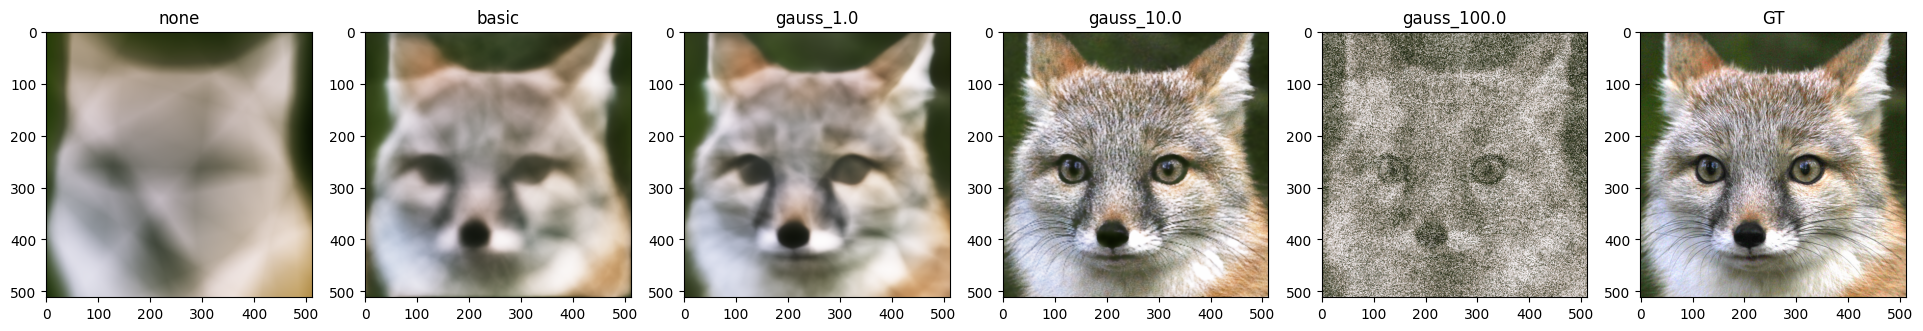

In [12]:
plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N + 1, i + 1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N + 1, N + 1)
plt.imshow(img)
plt.title('GT')
plt.show()

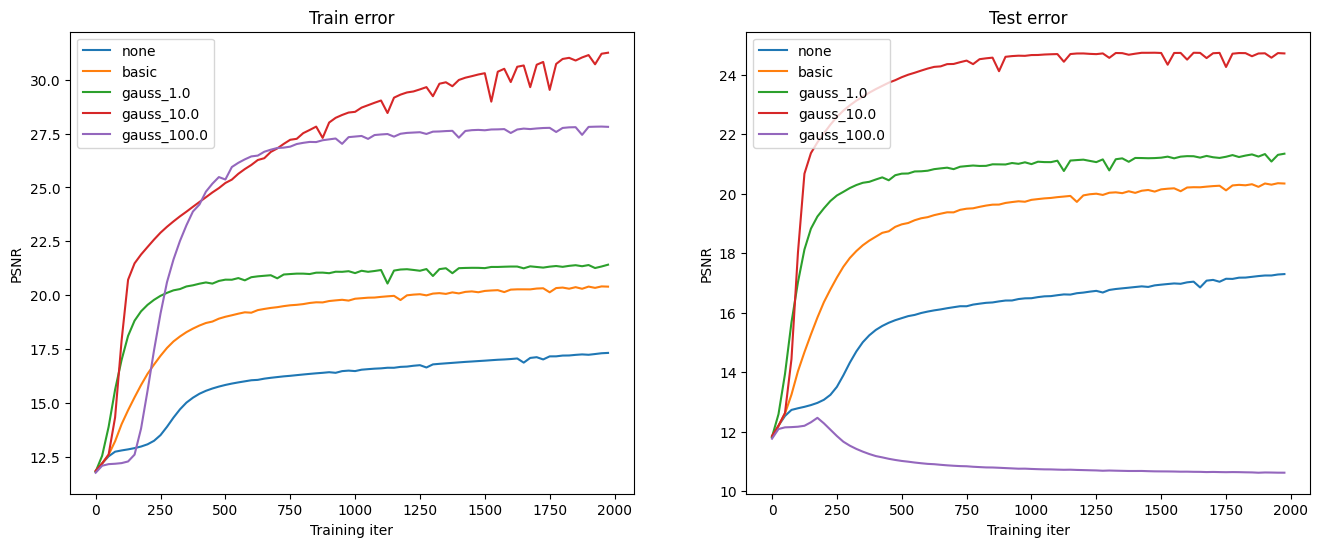

In [13]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [ ]:
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=2)  # Concatenate along width
data8 = (255 * np.clip(all_preds, 0, 1)).astype(np.uint8)

f = 'training_convergence.mp4'
imageio.mimwrite(f, data8, fps=20)

mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f'''
<video width=1000 controls autoplay loop>
    <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join([f'<td width="{1000//len(outputs)}"></td>' for _ in outputs])}</tr>
  <tr>{''.join([f'<td style="text-align:center">{name}</td>' for name in outputs.keys()])}</tr>
</table>
''')